In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import summary_table
import pickle
import numpy as np
import os
import sys
#color blind color palette
CB_blue = '#377eb8'
CB_lightblue = '#adbccc'
CB_orange = '#ff7f00'
CB_lightorange = '#ffd9b3'
CB_green = '#4daf4a'
CB_pink = '#f781bf'
CB_brown = '#a65628'
CB_purple = '#984ea3'
CB_gray = '#999999'
CB_red = '#e41a1c'
CB_yellow = '#dede00'

In [16]:
os.makedirs('plots/export/img/filter', exist_ok=True)
os.makedirs('plots/export/img/comparison', exist_ok=True)
os.makedirs('plots/export/img/uncert_dl', exist_ok=True)
os.makedirs('plots/export/img/uncert_wateredge', exist_ok=True)
os.makedirs('plots/export/img/dl_uncert_metric', exist_ok=True)
os.makedirs('plots/export/img/wateredge_uncert_metric', exist_ok=True)
os.makedirs('plots/export/tables', exist_ok=True)

In [17]:
subset = "GRO21"
if get_ipython().__class__.__name__ != 'ZMQInteractiveShell':
    if len(sys.argv)>1:
        subset = sys.argv[1]
directory = f"plots/{subset}"

In [18]:
def spike_indexes(df_column, span, delta):
    # Forwards EWMA.
    fwd = pd.Series.ewm(df_column, span=span).mean()
    # Backwards EWMA.
    bwd = pd.Series.ewm(df_column[::-1],span=span).mean()
    # Add and take the mean of the forwards and backwards EWMA.
    stacked_ewma = np.vstack((fwd, bwd[::-1]))
    fb_ewma = np.mean(stacked_ewma, axis=0)
    # Calculate the difference between the EWMA and the original series. If greater than delta, return the index to remove.
    cond = (np.abs(df_column-fb_ewma) > delta)
    return cond

def moving_avg_std(df, window_size):
    # fwd = df.rolling(window_size)
    # bwd = df[::-1].rolling(window_size)
    fwd = pd.Series.ewm(df, span=window_size)
    bwd = pd.Series.ewm(df[::-1],span=window_size)
    stacked_avg = np.vstack((fwd.mean(), bwd.mean()[::-1]))
    stacked_std = np.vstack((fwd.std(), bwd.std()[::-1]))
    avg = np.mean(stacked_avg, axis=0)
    std = np.mean(stacked_std, axis=0)
    avg[0]=avg[1]
    avg[-1]=avg[-2]
    std[0]=std[1]
    std[-1]=std[-2]
    return avg, std

def rmse(predictions, targets):
    return np.sqrt(((predictions-targets)**2).mean())
def mse(predictions, targets):
    return ((predictions-targets)**2).mean()

In [19]:
np.linspace(2,8,10+1)

array([2. , 2.6, 3.2, 3.8, 4.4, 5. , 5.6, 6.2, 6.8, 7.4, 8. ])

In [20]:

def calc_bins(predicted_wse, true_wse, uncertainty):

  num_bins = 10
  bin_ranges = np.linspace(uncertainty.min(), uncertainty.max(), num_bins+1)
  assert len(bin_ranges)==num_bins+1
  binned = np.digitize(uncertainty, bin_ranges)-1
  binned[binned==num_bins] = num_bins-1
  assert binned.min() == 0
  assert binned.max() == num_bins-1

  bin_mse = np.zeros(num_bins)
  bin_uncert = np.zeros(num_bins)
  bin_sizes = np.zeros(num_bins, dtype=int)

  for bin in range(num_bins):
    bin_sizes[bin] = len(predicted_wse[binned == bin])
    if bin_sizes[bin] > 0:
      bin_mse[bin] = mse(true_wse[binned==bin], predicted_wse[binned==bin])
      bin_uncert[bin] = uncertainty[binned==bin].mean()
  assert sum(bin_sizes) == len(predicted_wse)
  return num_bins, bin_ranges, binned, bin_mse, bin_uncert, bin_sizes
def get_uce(predicted_wse, true_wse, uncertainty):
  UCE = 0
  num_bins, bins_ranges, binned, bin_mse, bin_uncert, bin_sizes = calc_bins(predicted_wse, true_wse, uncertainty)
  for i in range(num_bins):
    if bin_sizes[i] > 0:
      UCE += bin_sizes[i]*abs(bin_mse[i] - bin_uncert[i])/bin_uncert[i]
  return UCE/len(uncertainty)/num_bins

In [21]:
# *_raster_val.txt files need to have the following columns: chainage, elevation, and RASTERVALU.
centerline = pd.read_csv(f'{directory}/centerline.csv', sep=',', header=[0]).sort_values(by='chainage')
wateredge = pd.read_csv(f'{directory}/wateredge.csv', sep=',', header=[0]).sort_values(by='chainage')

In [22]:
with open(f'{directory}/valid.pickle', 'rb') as f:
    result_dict = pickle.load(f)

In [23]:
dl_chainage = result_dict["info"]["chain"]
dl_true_wse = result_dict["info"]["wse"]
dl_predicted_wse = result_dict["predict"].mean(axis=0)
# dl_chainage = dl_chainage - dl_chainage.min()
dl_ols = sm.OLS(dl_predicted_wse, sm.add_constant(dl_chainage)).fit()
dl_ols_predicted_wse = dl_ols.fittedvalues
dl_moving_avg, dl_moving_std = moving_avg_std(dl_predicted_wse, 10)

In [24]:
SPAN = 50
DELTA = 0.1
wateredge = wateredge[(wateredge["chainage"]>dl_chainage.min()) & (wateredge["chainage"]<dl_chainage.max())]
centerline = centerline[(centerline["chainage"]>dl_chainage.min()) & (centerline["chainage"]<dl_chainage.max())]
wateredge_ = wateredge.copy()
centerline_ = centerline.copy()
for _ in range(3):
    remove_indexes = spike_indexes(wateredge["raster_value"], SPAN, DELTA)
    wateredge = wateredge[~remove_indexes]
    remove_indexes = spike_indexes(centerline["raster_value"], SPAN, DELTA)
    centerline = centerline[~remove_indexes]

wateredge_ols = sm.OLS(wateredge["raster_value"], sm.add_constant(wateredge['chainage'])).fit()
wateredge_ols_predicted_wse = wateredge_ols.fittedvalues
wateredge_moving_avg, wateredge_moving_std = moving_avg_std(wateredge["raster_value"], 300)

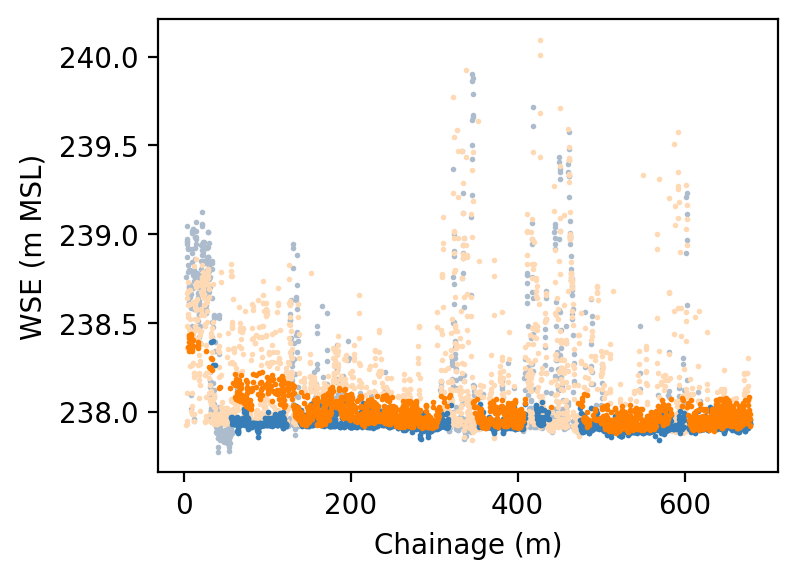

In [25]:
plt.figure(figsize=(4, 3), dpi=200)
plt.tight_layout()
plt.plot(centerline_['chainage'], centerline_['raster_value'], CB_lightblue, marker=".", linestyle="None", markersize=2, label='DEM centerline (raw)')
plt.plot(wateredge_['chainage'], wateredge_['raster_value'], CB_lightorange, marker=".", linestyle="None", markersize=2, label='DEM wateredge (raw)')
plt.plot(centerline['chainage'], centerline['raster_value'], CB_blue, marker=".", linestyle="None", markersize=2, label='DEM centerline (filtered)')
plt.plot(wateredge['chainage'], wateredge['raster_value'], CB_orange, marker=".", linestyle="None", markersize=2, label='DEM wateredge (filtered)')
plt.xlabel('Chainage (m)')
plt.ylabel('WSE (m MSL)')
# plt.legend(framealpha=1)
plt.savefig(f'plots/export/img/filter/{subset}.png', bbox_inches='tight')
if get_ipython().__class__.__name__ == 'ZMQInteractiveShell':
    plt.show()

CB_blue = '#377eb8'
CB_orange = '#ff7f00'
CB_green = '#4daf4a'
CB_pink = '#f781bf'
CB_brown = '#a65628'
CB_purple = '#984ea3'
CB_gray = '#999999'
CB_red = '#e41a1c'
CB_yellow = '#dede00'

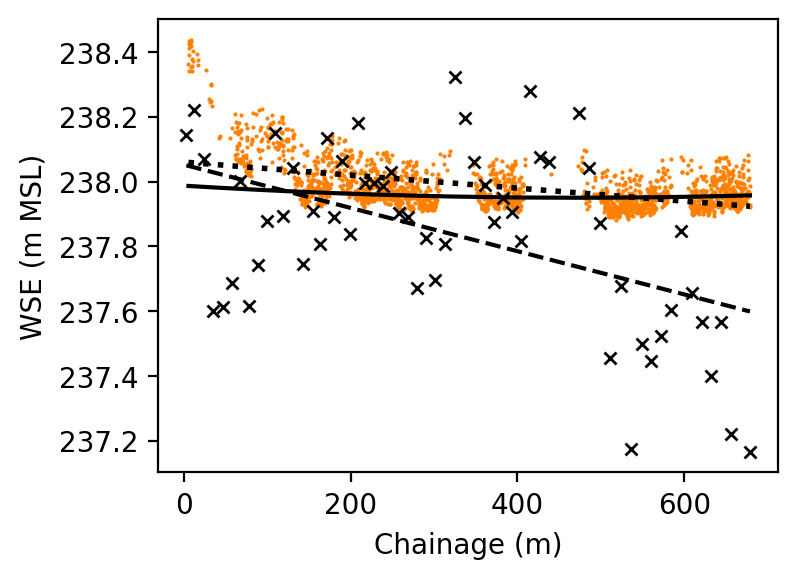

____RMSEs:
CNN: 0.29378945801735734
CNN Regression: 0.17224963357134915
CNN Moving Average: 0.20680820415077644
DEM Centerline: 0.04345319736789221
DEM Wateredge: 0.07501616713253222
DEM Wateredge Regression: 0.041641467233476205
DEM Wateredge Moving Average: 0.054024822416784905


In [26]:
plt.figure(figsize=(4, 3), dpi=200)
plt.tight_layout()
#plt.plot(centerline['chainage'], centerline['raster_value'], CB_blue, marker=".", linestyle="None", markersize=1, label='DEM centerline')
plt.plot(wateredge['chainage'], wateredge['raster_value'], CB_orange, marker=".", linestyle="None", markersize=1, label='DEM wateredge')
plt.plot(wateredge['chainage'], wateredge_ols_predicted_wse, ":", color="black", linewidth=2, label='DEM wateredge - regression')

# plt.plot(wateredge['chainage'], wateredge_moving_avg, ":", color="black", label='DEM wateredge - moving average')
plt.plot(dl_chainage,dl_predicted_wse, "x", label="CNN", color="black", markersize=4)
plt.plot(dl_chainage,dl_ols_predicted_wse, "--", label="CNN regression", color="black")
# plt.plot(dl_chainage,dl_moving_avg, "--", label="CNN moving average", color="black")
plt.plot(wateredge['chainage'],wateredge['true_wse'], "-", label="Ground truth", color="black")
plt.xlabel('Chainage (m)')
plt.ylabel('WSE (m MSL)')
#plt.legend(framealpha=1)
#plt.ylim([210,215])
plt.savefig(f'plots/export/img/comparison/{subset}.png', bbox_inches='tight')
if get_ipython().__class__.__name__ == 'ZMQInteractiveShell':
    plt.show()
#check if plots/export/tables/rmse.csv file exists
csv_path = 'plots/export/tables/rmse.csv'
if os.path.exists(csv_path):
    table = pd.read_csv("plots/export/tables/rmse.csv",index_col='subset')
else:
    table = pd.DataFrame(columns=['subset', 'dl_regression', 'waterege_regression', 'dl_points', 'wateredge_points'])
    table.set_index('subset', inplace=True)

table.loc[subset] = {'dl_regression': (rmse(dl_ols_predicted_wse,dl_true_wse)*100).round(1),
                      'waterege_regression': (rmse(wateredge_ols_predicted_wse,wateredge["true_wse"])*100).round(1),
                      'dl_points': (rmse(dl_predicted_wse,dl_true_wse)*100).round(1),
                      'wateredge_points': (rmse(wateredge_["raster_value"], wateredge_["true_wse"])*100).round(1)}.values()
table.to_csv("plots/export/tables/rmse.csv")

print("____RMSEs:")
print("CNN:",np.sqrt(((dl_predicted_wse-dl_true_wse)**2).mean()))
print("CNN Regression:",np.sqrt(((dl_ols_predicted_wse-dl_true_wse)**2).mean()))
print("CNN Moving Average:",np.sqrt(((dl_moving_avg-dl_true_wse)**2).mean()))
#print("Uncertainty:",(predict_upp-pred_y).mean())
print("DEM Centerline:",np.sqrt(((centerline["raster_value"]-centerline["true_wse"])**2).mean()))
print("DEM Wateredge:",np.sqrt(((wateredge["raster_value"]-wateredge["true_wse"])**2).mean()))
print("DEM Wateredge Regression:",np.sqrt(((wateredge_ols_predicted_wse-wateredge["true_wse"])**2).mean()))
print("DEM Wateredge Moving Average:",np.sqrt(((wateredge_moving_avg-wateredge["true_wse"])**2).mean()))
# print("DEM Wateredge Regression uncertainty:",(predict_upp_dsm-reg_dsm_).mean())

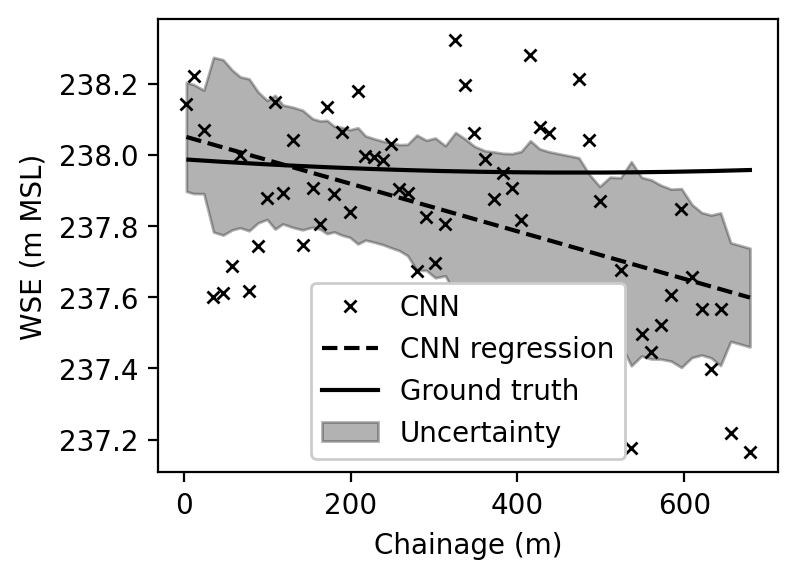

____Uncertainties:
DL Uncertainty: 0.1962193286221641


In [35]:
plt.figure(figsize=(4, 3), dpi=200)
plt.tight_layout()
plt.plot(dl_chainage,dl_predicted_wse, "x", label="CNN", color="black", markersize=4)
plt.plot(dl_chainage,dl_ols_predicted_wse, "--", label="CNN regression", color="black")
plt.plot(wateredge['chainage'],wateredge['true_wse'], "-", label="Ground truth", color="black")
plt.fill_between(dl_chainage, dl_ols_predicted_wse-dl_moving_std, dl_ols_predicted_wse+dl_moving_std, alpha=0.3, color="black", zorder=50, label="Uncertainty")
plt.xlabel('Chainage (m)')
plt.ylabel('WSE (m MSL)')
#plt.legend(framealpha=1).set_zorder(102)
plt.savefig(f'plots/export/img/uncert_dl/{subset}.png', bbox_inches='tight')
if get_ipython().__class__.__name__ == 'ZMQInteractiveShell':
    plt.show()
csv_path = 'plots/export/tables/uncert.csv'
if os.path.exists(csv_path):
    table = pd.read_csv("plots/export/tables/uncert.csv",index_col='subset')
else:
    table = pd.DataFrame(columns=['subset', 'dl', 'wateredge'])
    table.set_index('subset', inplace=True)
table.at[subset, "dl"] = (np.mean(dl_moving_std)*100).round(1)
table.to_csv("plots/export/tables/uncert.csv")

uce = get_uce(predicted_wse=dl_predicted_wse,true_wse=dl_true_wse,uncertainty=dl_moving_std)

csv_path = 'plots/export/tables/uce.csv'
if os.path.exists(csv_path):
    table = pd.read_csv("plots/export/tables/uce.csv",index_col='subset')
else:
    table = pd.DataFrame(columns=['subset', 'dl', 'wateredge'])
    table.set_index('subset', inplace=True)
table.at[subset, "dl"] = (uce*100).round(1)
table.to_csv("plots/export/tables/uce.csv")

# csv_path = 'plots/export/tables/mce.csv'
# if os.path.exists(csv_path):
#     table = pd.read_csv("plots/export/tables/mce.csv",index_col='subset')
# else:
#     table = pd.DataFrame(columns=['subset', 'dl', 'wateredge'])
#     table.set_index('subset', inplace=True)
# table.at[subset, "dl"] = mce
# table.to_csv("plots/export/tables/mce.csv")
print("____Uncertainties:")
print("DL Uncertainty:",np.nanmean(dl_moving_std))

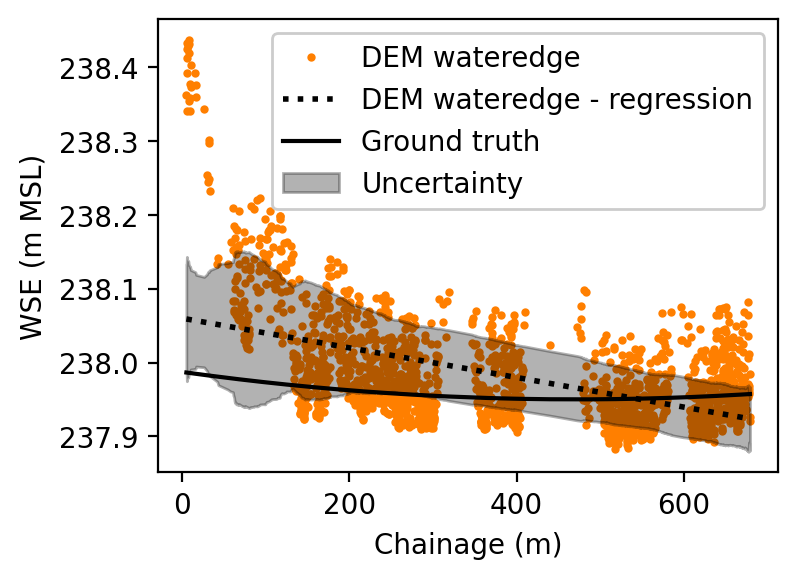

____Uncertainties:
Wateredge Uncertainty: 0.05153162005472549


In [37]:
from cProfile import label


plt.figure(figsize=(4, 3), dpi=200)
plt.tight_layout()
plt.plot(wateredge['chainage'], wateredge['raster_value'], CB_orange, marker=".", linestyle="None", markersize=1, label='DEM wateredge')
plt.plot(wateredge['chainage'], wateredge_ols_predicted_wse, ":", color="black", linewidth=2, label='DEM wateredge - regression')
# plt.plot(wateredge['chainage'], wateredge_moving_avg, ":", color="black", label='DEM wateredge - moving average')
plt.plot(wateredge['chainage'], wateredge['true_wse'], "-", label="Ground truth", color="black")
plt.fill_between(wateredge['chainage'], wateredge_ols_predicted_wse-wateredge_moving_std, wateredge_ols_predicted_wse+wateredge_moving_std, alpha=0.3, color="black", zorder=100, label="Uncertainty")
plt.xlabel('Chainage (m)')
plt.ylabel('WSE (m MSL)')
#plt.legend(framealpha=1).set_zorder(102)
plt.savefig(f'plots/export/img/uncert_wateredge/{subset}.png', bbox_inches='tight')
if get_ipython().__class__.__name__ == 'ZMQInteractiveShell':
    plt.show()
csv_path = 'plots/export/tables/uncert.csv'
if os.path.exists(csv_path):
    table = pd.read_csv("plots/export/tables/uncert.csv",index_col='subset')
else:
    table = pd.DataFrame(columns=['subset', 'dl', 'wateredge'])
    table.set_index('subset', inplace=True)
table.at[subset, "wateredge"] = (np.mean(wateredge_moving_std)*100).round(1)
table.to_csv("plots/export/tables/uncert.csv")

uce = get_uce(predicted_wse=wateredge_ols_predicted_wse,true_wse=wateredge['true_wse'],uncertainty=wateredge_moving_std)

csv_path = 'plots/export/tables/uce.csv'
if os.path.exists(csv_path):
    table = pd.read_csv("plots/export/tables/uce.csv",index_col='subset')
else:
    table = pd.DataFrame(columns=['subset', 'dl', 'wateredge'])
    table.set_index('subset', inplace=True)
table.at[subset, "wateredge"] = (uce*100).round(1)
table.to_csv("plots/export/tables/uce.csv")

# csv_path = 'plots/export/tables/mce.csv'
# if os.path.exists(csv_path):
#     table = pd.read_csv("plots/export/tables/mce.csv",index_col='subset')
# else:
#     table = pd.DataFrame(columns=['subset', 'dl', 'wateredge'])
#     table.set_index('subset', inplace=True)
# table.at[subset, "wateredge"] = mce
# table.to_csv("plots/export/tables/mce.csv")

print("____Uncertainties:")
print("Wateredge Uncertainty:",np.nanmean(wateredge_moving_std))
